In [76]:
%matplotlib notebook

# Dependencies

import os
import cv2
import merging_functions as mf
import numpy as np
import tracker as tr
import datetime

from scipy.optimize import curve_fit

from matplotlib import pyplot as plt

In [3]:
# Go through each merged file and collect the resized image in a numpy array
def get_image_sequence(video_folder, exp_name, acq_name, t_str, zstr_ar, img_dims):
    # Initialize the img numpy array
    img_seq = np.zeros((img_dims[0], img_dims[1], len(zstr_ar)), np.uint8)
    # Go over each z-stack image
    video_path = os.path.join(video_folder, f"{exp_name}_{acq_name}", f"{exp_name}_{acq_name}_{t_str}.avi")
    
    # Video capture object
    vidcap = cv2.VideoCapture(video_path)
    for zix in range(len(zstr_ar)):
        z_str = zstr_ar[zix]
        # Collect the path of the merged files
        try:
            success, frame = vidcap.read()
            
            # Convert to grayscale
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Add to image sequence array
            img_seq[:,:,zix] = frame_gray

        except Exception as e:
            print(success)
            print(f"Error! Cannot read video from path {video_path}")
        
    return img_seq

In [ ]:
def collect_radial_data(roi_img, Rar_pxl):
    height, width = roi_img.shape
    centerx = np.int32(width/2)
    centery = np.int32(height/2)
    
    central_sum = np.zeros_like(Rar_pxl, dtype=np.double)
    for Rix in range(len(Rar_pxl)):
        radius = Rar_pxl[Rix]
        circle_img = np.zeros((height,width), np.uint8)
        cv2.circle(circle_img,(centerx,centery), radius,1,thickness=-1)
        masked_data = cv2.bitwise_and(roi_img, roi_img, mask=circle_img)

        central_sum[Rix] = masked_data.sum()/circle_img.sum()/255.0
        
    return central_sum

In [48]:
def collect_maxradial_data(roi_img, RR):
    height, width = roi_img.shape
    centerx = np.int32(width/2)
    centery = np.int32(height/2)
    
    radius = RR
    circle_img = np.zeros((height,width), np.uint8)
    cv2.circle(circle_img,(centerx,centery), radius,1,thickness=-1)
    masked_data = cv2.bitwise_and(roi_img, roi_img, mask=circle_img)

    central_sum = masked_data.sum()/circle_img.sum()/255.0
        
    return central_sum

## Test for height and radius for several acq_name

In [6]:
exp_name = "EQ59_Gly_03232021"
acq_name = "TileScan_Tp34-57_xyzt"
inner = True
img_dims = (512,512)

exp_folder = os.path.join("D:", "Tolga", "Colony Images", exp_name)
metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner)

t_str = "t08"

zsz = metadata["dimensions"]["Z"]["NumberOfElements"]
# Find the number of digits
znum_digit = len(str(zsz))
# zstr for file path
zstr_holder = f"z%0{znum_digit}d"

# calculate z_strar for each z_str value
z_strar = np.zeros(zsz, dtype="<U6")
for zix in range(zsz):
    z_strar[zix] = zstr_holder % zix


video_folder = os.path.join(exp_folder, "Videos_ROI_Unmarked")

img_seq = get_image_sequence(video_folder, exp_name, acq_name, t_str, z_strar, img_dims)

In [7]:
metadata

{'dimensions': {'X': {'Length': 930.0,
   'NumberOfElements': 1024,
   'Unit': 'um',
   'Voxel': 0.909},
  'Y': {'Length': 930.0,
   'NumberOfElements': 1024,
   'Unit': 'um',
   'Voxel': 0.909},
  'Z': {'Length': -1000.0,
   'NumberOfElements': 235,
   'Unit': 'um',
   'Voxel': -4.0},
  'Stage': {'Length': '0.00',
   'NumberOfElements': 36,
   'Unit': '',
   'Voxel': None},
  'T': {'Length': '23h37m51.780s',
   'NumberOfElements': 24,
   'Unit': '',
   'Voxel': '0 s'}},
 'tiles': {'xix_lst': array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
         3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5]),
  'yix_lst': array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
         4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]),
  'xix_unique_ar': array([0, 1, 2, 3, 4, 5]),
  'yix_unique_ar': array([0, 1, 2, 3, 4, 5]),
  'xpos_lst': array([79467.7301568, 79467.7301568, 79467.7301568, 79467.7301568,
         79467.7301568, 79467.7301568, 80368.6872288, 80368.6872

## Surface z-indices|

In [120]:
top_threshold = 8e5 # Threshold pixel
top_ratio = 0.02
um_per_pxl = 12.67408288

# Glycerol plate time
plate_time_obj = datetime.datetime(2021, 3, 21, 4, 30)
exp_name = "EQ59_Glu_03142021"
acq_name_ar = ["TileScan_12-24h_xyzt",
               "TileScan_24-48h_xyzt",
               "TileScan_48h-72h_xyzt"]
inner = False
radius = radius_glu/um_per_pxl
zhtop_ixar = []
zsurf_ixar = []

time = []
height = []

plt_seq = [[],[]]
tpix = 0
tpix = 0
for acix in range(len(acq_name_ar)):
    acq_name = acq_name_ar[acix]
    print(f"Calculating for {acq_name}")
    exp_folder = os.path.join("D:", "Tolga", "Colony Images", exp_name)
    metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner)
    video_folder = os.path.join(exp_folder, "Videos_ROI_Unmarked")

    zsz = metadata["dimensions"]["Z"]["NumberOfElements"]
    zvoxel = metadata["dimensions"]["Z"]["Voxel"]
    # Find the number of digits
    znum_digit = len(str(zsz))
    # zstr for file path
    zstr_holder = f"z%0{znum_digit}d"

    tsz = metadata["dimensions"]["T"]["NumberOfElements"]
    # Find the number of digits
    tnum_digit = len(str(tsz))
    # zstr for file path
    tstr_holder = f"t%0{tnum_digit}d"

    # calculate z_strar for each z_str value
    z_strar = np.zeros(zsz, dtype="<U6")
    for zix in range(zsz):
        z_strar[zix] = zstr_holder % zix

    # Choose surface z values and surface image
    #     zsurf_ixar = np.zeros(tsz, dtype=np.int)
    #     surf_imagear = np.zeros((img_dims[0], img_dims[1], tsz))
    # Calculate initial time
    start_time = metadata["start_time"]
    initial_time_h = (start_time - plate_time_obj).total_seconds() / 3600

    # Calculate dt
    timedelta_str = metadata["dimensions"]["T"]["Length"]
    hour = int(timedelta_str.split("h")[0])
    minute = int(timedelta_str.split("h")[1].split("m")[0])
    second = float(timedelta_str.split("h")[1].split("m")[1].split("s")[0])
    dt = (datetime.timedelta(hours = hour, minutes = minute, seconds=second)/tsz).total_seconds()/3600

    # Choose a single timepoint and check
    zar = np.arange(zsz)
    for tix in range(tsz):
        t_str = tstr_holder % tix
        print(f"At t={tix}/{tsz} (tstr={t_str})", end="\r", flush=True)
        if acq_name == "TileScan_Tp34-57_xyzt" and tix > 8:
            break
        img_seq = get_image_sequence(video_folder, exp_name, acq_name, t_str, z_strar, img_dims)
        total_pxl = np.zeros(zsz)
        for zix in range(zsz):
            roi_img = img_seq[:,:,zix]
            total_pxl[zix] = collect_maxradial_data(roi_img, int(radius[tpix]))
        plt_seq[0].append(zar)
        plt_seq[1].append(total_pxl/total_pxl.max())
        zsurf_ix = np.argmax(total_pxl)
        surf_img = img_seq[:,:,zsurf_ix]
        
#         # Absolute value threshold
#         zhtop_ix = np.where((total_pxl > top_threshold))[0][0]
        # Ratio threshold
        zhtop_ix = np.where((total_pxl > top_ratio))[0][0]
        tpix += 1
        

        zsurf_ixar.append(zsurf_ix)
        zhtop_ixar.append(zhtop_ix)
        # Add time information
        time.append(initial_time_h + dt*tix)
        height.append((zhtop_ix - zsurf_ix)*zvoxel)
        


Calculating for TileScan_12-24h_xyzt
Calculating for TileScan_24-48h_xyzt
Calculating for TileScan_48h-72h_xyzt


<IPython.core.display.Javascript object>


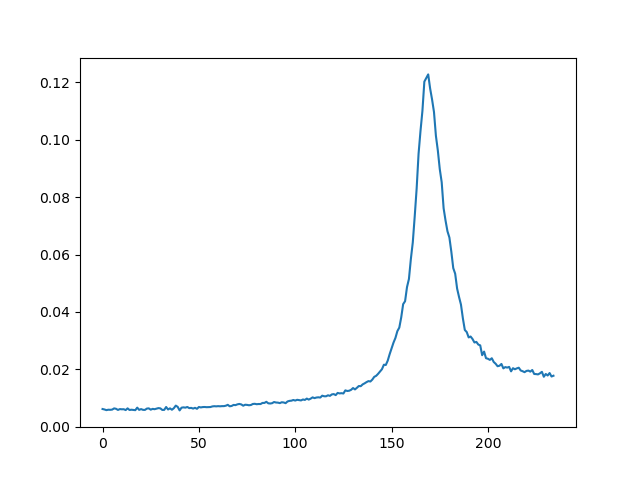

In [126]:
fig,ax = plt.subplots()
ax.plot(total_pxl)

<IPython.core.display.Javascript object>


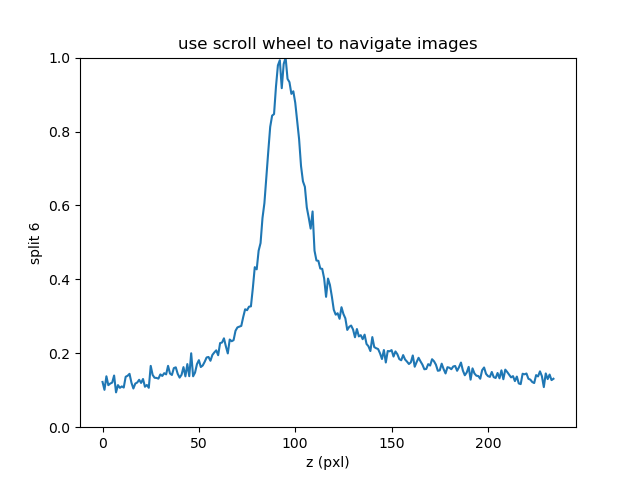

In [122]:
fig_maxint_img, ax = plt.subplots()
tracker = tr.IndexTracker(ax, plt_seq, "line_lst", "-", 10)
#     ax.set_xlim(0,40)
ax.set_ylim(0,1)
ax.set_xlabel("z (pxl)")
ax.set_ylabel("Average pixel brightness")
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

<IPython.core.display.Javascript object>


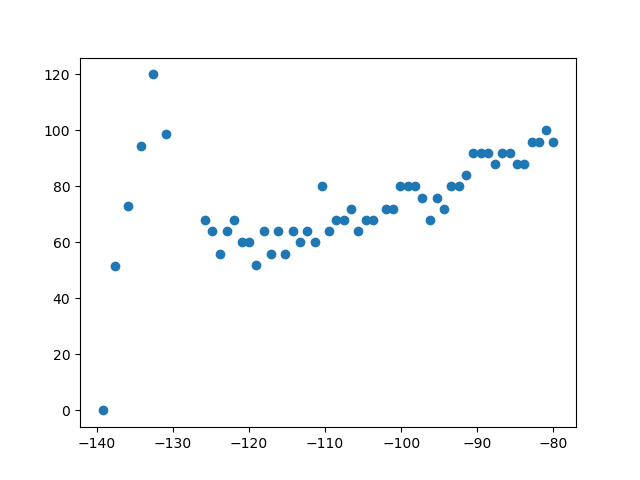

In [123]:
fig,ax = plt.subplots()
ax.plot(time, height, 'o')

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.arange(zsz), total_pxl, 'o')
ax.set_ylim(0,1e6)

## Calculate time and radius at the surface

In [ ]:
# Glycerol plate time
plate_time_obj = datetime.datetime(2021, 3, 21, 4, 30)
exp_name = "EQ59_Gly_03232021"
acq_name_ar = ["TileScan_Tp1-9_xyzt",
               "TileScan_Tp10-33_xyzt",
               "TileScan_Tp34-57_xyzt"]
inner = True

# # Glucose plate time
# plate_time_obj = datetime.datetime(2021, 3, 14, 23, 30)
# exp_name = "EQ59_Glu_03142021"
# acq_name_ar = ["TileScan_12-24h_xyzt",
#                "TileScan_24-48h_xyzt",
#                "TileScan_48h-72h_xyzt"]
# inner = False

img_dims = (512,512)


zsurf_ixar = []
radius = []
time = []
dr = 1
Rar_pxl = np.arange(1,img_dims[0]/2, dr, dtype=np.int32)

for acix in range(len(acq_name_ar)):
    acq_name = acq_name_ar[acix]
    print(f"Calculating for {acq_name}")
    exp_folder = os.path.join("D:", "Tolga", "Colony Images", exp_name)
    metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner)
    video_folder = os.path.join(exp_folder, "Videos_ROI_Unmarked")
    
    zsz = metadata["dimensions"]["Z"]["NumberOfElements"]
    # Find the number of digits
    znum_digit = len(str(zsz))
    # zstr for file path
    zstr_holder = f"z%0{znum_digit}d"
    
    tsz = metadata["dimensions"]["T"]["NumberOfElements"]
    # Find the number of digits
    tnum_digit = len(str(tsz))
    # zstr for file path
    tstr_holder = f"t%0{tnum_digit}d"

    # calculate z_strar for each z_str value
    z_strar = np.zeros(zsz, dtype="<U6")
    for zix in range(zsz):
        z_strar[zix] = zstr_holder % zix
    
    # Choose surface z values and surface image
#     zsurf_ixar = np.zeros(tsz, dtype=np.int)
#     surf_imagear = np.zeros((img_dims[0], img_dims[1], tsz))
    # Calculate initial time
    start_time = metadata["start_time"]
    initial_time_h = (start_time - plate_time_obj).total_seconds() / 3600
    
    # Calculate dt
    timedelta_str = metadata["dimensions"]["T"]["Length"]
    hour = int(timedelta_str.split("h")[0])
    minute = int(timedelta_str.split("h")[1].split("m")[0])
    second = float(timedelta_str.split("h")[1].split("m")[1].split("s")[0])
    dt = (datetime.timedelta(hours = hour, minutes = minute, seconds=second)/tsz).total_seconds()/3600
    for tix in range(tsz):
        if acix == 2 and tix > 8:
            break
        t_str = tstr_holder % tix
        print(f"At t={tix}/{tsz} (tstr={t_str})", end="\r", flush=True)

        img_seq = get_image_sequence(video_folder, exp_name, acq_name, t_str, z_strar, img_dims)
        total_pxl = np.zeros(zsz)
        for zix in range(zsz):
            total_pxl[zix] = img_seq[:,:,zix].sum()
        
        zsurf_ix = np.argmax(total_pxl)
        surf_image = img_seq[:,:,zsurf_ix]
        
        zsurf_ixar.append(zsurf_ix)
        central_avg = collect_radial_data(surf_image, Rar_pxl)
        ###################
        # Calculate the colony radius for each timepoint
        ###################
        # Calculate the difference of central avg
        diff_central_avg = np.diff(central_avg, prepend=0)
        # Find the last point that is positive, and call it the radius
        filterar = diff_central_avg > 0
        brightness = central_avg[filterar][-1]
        if brightness > 0.1:
            radius.append(Rar_pxl[filterar][-1])
        else:
            radius.append(0)
        
        # Add time information
        time.append(initial_time_h + dt*tix)

In [ ]:
time = []
microns_per_pixel = metadata["dimensions"]["X"]["Voxel"]
for acix in range(len(acq_name_ar)):
    acq_name = acq_name_ar[acix]
    print(f"Calculating for {acq_name}")
    exp_folder = os.path.join("D:", "Tolga", "Colony Images", exp_name)
    metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner)
    
    tsz = metadata["dimensions"]["T"]["NumberOfElements"]

    start_time = metadata["start_time"]
    initial_time_h = (start_time - plate_time_obj).total_seconds() / 3600
    # Calculate dt
    timedelta_str = metadata["dimensions"]["T"]["Length"]
    hour = int(timedelta_str.split("h")[0])
    minute = int(timedelta_str.split("h")[1].split("m")[0])
    second = float(timedelta_str.split("h")[1].split("m")[1].split("s")[0])
    dt = (datetime.timedelta(hours = hour, minutes = minute, seconds=second)/tsz).total_seconds()/3600
    for tix in range(tsz):
        time.append(initial_time_h + dt*tix)

In [ ]:
microns_per_pixel = metadata["dimensions"]["X"]["Voxel"]
fig,ax = plt.subplots()
ax.plot(time, np.array(radius)*microns_per_pixel*1800/512, 'o')
# ax.set_xlim(0,50)
# ax.set_ylim(0,400)
# ax.set_xticks(np.arange(13,28))

In [63]:
height

[-0.0,
 -0.0,
 180.01199999999997,
 -0.0,
 244.30199999999996,
 21.43,
 25.715999999999998,
 47.145999999999994,
 55.717999999999996,
 60.0,
 52.0,
 64.0,
 64.0,
 68.0,
 56.0,
 56.0,
 60.0,
 64.0,
 68.0,
 64.0,
 68.0,
 64.0,
 72.0,
 72.0,
 68.0,
 64.0,
 64.0,
 64.0,
 68.0,
 64.0,
 68.0,
 64.0,
 60.0,
 64.0,
 64.0,
 60.0,
 56.0,
 56.0,
 56.0,
 52.0,
 52.0,
 52.0]

## Debugging for the current timepoint. For each z sections

In [ ]:
height,width, zsz = img_seq.shape
dr = 1
Rar_pxl = np.arange(1,width/2, dr, dtype=np.int32)
plt_seq = np.zeros((2,len(Rar_pxl), zsz))

for zix in range(zsz):
    roi_image = img_seq[:,:,zix]
    blurred_image = cv2.GaussianBlur(roi_image, (15,15), 0).astype(np.uint8)
#     blurred_image = roi_image
    if zix%10 == 0:
        print(f"Calculating zix = {zix}/{zsz}", end="\r", flush=True)
    central_avg = collect_radial_data(blurred_image, Rar_pxl)
    plt_seq[0,:,zix] = Rar_pxl
    plt_seq[1,:,zix] = central_avg
    

In [ ]:
fig_maxint_img, ax = plt.subplots(figsize=(4,4), dpi=200)
tracker = tr.IndexTracker(ax, plt_seq, "line", "-", 70)
#     ax.set_xlim(0,40)
ax.set_ylim(0,1)
ax.set_xlabel("Radius (pxl)")
ax.set_ylabel("Average pixel brightness")
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

## Manual Radius measurements

In [81]:
def read_time(exp_name, acq_name_ar, inner, plate_time_obj):
    time = []
    for acix in range(len(acq_name_ar)):
        acq_name = acq_name_ar[acix]
        print(f"Calculating for {acq_name}")
        exp_folder = os.path.join("D:", "Tolga", "Colony Images", exp_name)
        metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner)

        # Number of t values
        tsz = metadata["dimensions"]["T"]["NumberOfElements"]
        if acq_name == "TileScan_Tp34-57_xyzt":
            tsz = 9
        # Calculate initial time
        start_time = metadata["start_time"]
        initial_time_h = (start_time - plate_time_obj).total_seconds() / 3600
        if acq_name == "TileScan_12-24h_xyzt":
            initial_time_h += 2.5
            
        # Calculate dt
        timedelta_str = metadata["dimensions"]["T"]["Length"]
        hour = int(timedelta_str.split("h")[0])
        minute = int(timedelta_str.split("h")[1].split("m")[0])
        second = float(timedelta_str.split("h")[1].split("m")[1].split("s")[0])
        dt = (datetime.timedelta(hours = hour, minutes = minute, seconds=second)/tsz).total_seconds()/3600
        # Add time information
        for tix in range(tsz):
            time.append(initial_time_h + dt*tix)
            
    return np.array(time)

In [112]:
# Mya's data on Glucose
time_Mya = np.array([13.1167,14.3333,16.0667,17.6167,18.7667,19.1667,19.35,20.2833,20.45,20.75,21.0667,21.8167,22.0667,22.5833,23.3167,23.4,23.7167,23.8,24.4833,25.1333,25.3,25.9833,26.05,26.6833,26.8167,27.55,27.7833,28.0333,28.0333,28.25,28.7833,28.9333,29.5667,30.3,30.4667,31.0667,32.2167,33.7833,34.4,35.35,43.5,50.6])
radius_Mya = np.array([67.8,77.8,122.5,194.6,271,288.3,307.1,344.5,370.5,403.6,382,418.1,442.6,458.4,487.3,533.4,506,504.6,542,539.2,593.9,582.4,604,606.9,644.4,670.3,658.8,683.3,712.1,670.3,736.7,706.4,771.3,794.3,771.3,828.9,810.2,875,873.6,944.2,1151.8,1394])
height_Mya = np.array([0.8977,16.3106,28.3378,46.6102,64.231,70.2828,103.6576,91.7915,90.6366,107.8873,112.8813,119.2242,126.6454,134.3621,133.4505,143.5929,152.4535,138.8572,148.4291,149.1478,146.4433,153.1103,154.9891,152.2291,156.6646,159.1836,162.9477,166.5102,162.787,164.679,160.7124,169.2638,177.2257,171.195,172.584,173.1426,182.179,186.8484,187.5762,195.2832,220.3114,207.9188])

In [83]:
# Glycerol
plate_time_obj = datetime.datetime(2021, 3, 21, 4, 30)
exp_name = "EQ59_Gly_03232021"
acq_name_ar = ["TileScan_Tp1-9_xyzt",
               "TileScan_Tp10-33_xyzt",
               "TileScan_Tp34-57_xyzt"]
inner = True
time_gly = read_time(exp_name, acq_name_ar, inner, plate_time_obj)

Calculating for TileScan_Tp1-9_xyzt
Calculating for TileScan_Tp10-33_xyzt
Calculating for TileScan_Tp34-57_xyzt


In [84]:
# Glucose
plate_time_obj = datetime.datetime(2021, 3, 14, 23, 30)
exp_name = "EQ59_Glu_03142021"
acq_name_ar = ["TileScan_12-24h_xyzt",
               "TileScan_24-48h_xyzt",
               "TileScan_48h-72h_xyzt"]
inner = False
time_glu = read_time(exp_name, acq_name_ar, inner, plate_time_obj)

Calculating for TileScan_12-24h_xyzt
Calculating for TileScan_24-48h_xyzt
Calculating for TileScan_48h-72h_xyzt


In [85]:
radius_gly = np.array([0,0,0,0,21.73913043,43.47826087,86.95652174,125,211.9565217,320.6521739,353.2608696,375,413.0434783,440.2173913,461.9565217,489.1304348,516.3043478,538.0434783,570.6521739,592.3913043,619.5652174,652.173913,673.9130435,695.6521739,728.2608696,744.5652174,777.173913,793.4782609,820.6521739,842.3913043,875,913.0434783,929.3478261,945.6521739,978.2608696,994.5652174,1000,1005.434783,1016.304348,1027.173913,1043.478261,1048.913043])
height_gly = np.array([-0.0, -0.0, 180.01199999999997, -0.0, 244.30199999999996, 21.43, 25.715999999999998, 47.145999999999994, 55.717999999999996, 60.0, 52.0, 64.0, 64.0, 68.0, 56.0, 56.0, 60.0, 64.0, 68.0, 64.0, 68.0, 64.0, 72.0, 72.0, 68.0, 64.0, 64.0, 64.0, 68.0, 64.0, 68.0, 64.0, 60.0, 64.0, 64.0, 60.0, 56.0, 56.0, 56.0, 52.0, 52.0, 52.0])
radius_glu = np.array([0,59.7826087,146.7391304,228.2608696,353.2608696,418.4782609,543.4782609,592.3913043,625,657.6086957,690.2173913,701.0869565,755.4347826,793.4782609,836.9565217,869.5652174,913.0434783,940.2173913,967.3913043,989.1304348,1027.173913,1048.913043,1065.217391,1092.391304,1114.130435,1130.434783,1152.173913,1173.913043,1184.782609,1211.956522,1217.391304,1233.695652,1255.434783,1260.869565,1277.173913,1293.478261,1298.913043,1304.347826,1320.652174,1326.086957,1336.956522,1347.826087,1353.26087,1364.130435,1364.130435,1380.434783,1385.869565,1385.869565,1402.173913,1407.608696,1413.043478,1413.043478,1413.043478,1413.043478])
height_glu = np.array([-0.0, 51.431999999999995, 72.862, 94.29199999999999, 120.00799999999998, 98.57799999999999, 68.0, 64.0, 56.0, 64.0, 68.0, 60.0, 60.0, 52.0, 64.0, 56.0, 64.0, 56.0, 64.0, 60.0, 64.0, 60.0, 80.0, 64.0, 68.0, 68.0, 72.0, 64.0, 68.0, 68.0, 72.0, 72.0, 80.0, 80.0, 80.0, 76.0, 68.0, 76.0, 72.0, 80.0, 80.0, 84.0, 92.0, 92.0, 92.0, 88.0, 92.0, 92.0, 88.0, 88.0, 96.0, 96.0, 100.0, 96.0])

## Radius

<IPython.core.display.Javascript object>


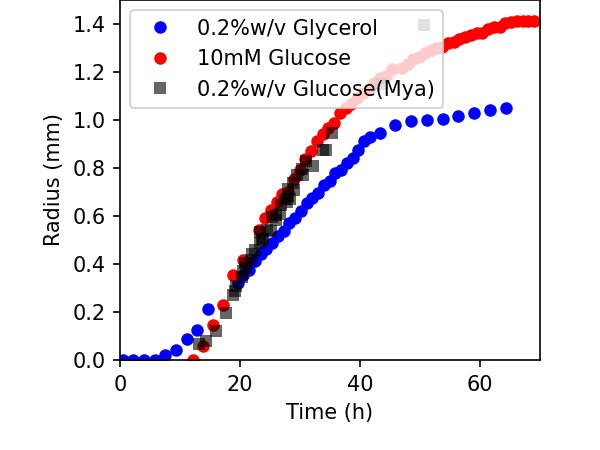

Text(0, 0.5, 'Radius (mm)')

In [143]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
plt.subplots_adjust(left=0.2, top=1, bottom=0.2)
ax.plot(time_gly, radius_gly/1e3, 'o', color=(0,0,1,1), label="0.2%w/v Glycerol", markeredgewidth=0, markersize=6)
ax.plot(time_glu, radius_glu/1e3, 'o', color=(1,0,0,1), label="10mM Glucose", markeredgewidth = 0, markersize=6)
ax.plot(time_Mya, radius_Mya/1e3, 's', color=(0,0,0,0.6), label="0.2%w/v Glucose(Mya)", markeredgewidth = 0, markersize=6)
ax.legend()
ax.set_xlim(0,70)
ax.set_ylim(0,1.5)
ax.set_xlabel(r"Time (h)")
ax.set_ylabel(r"Radius (mm)")

## Height

<IPython.core.display.Javascript object>


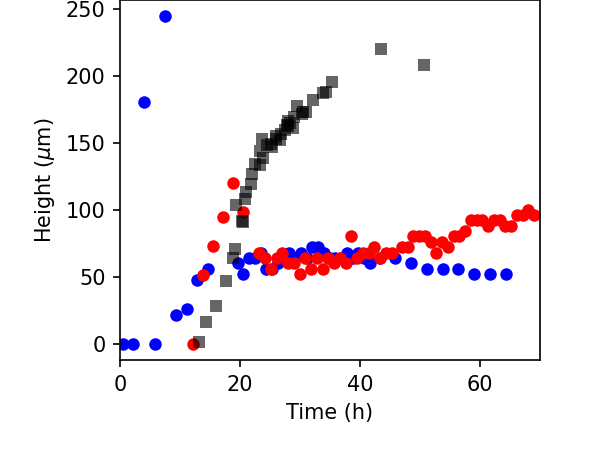

Text(0, 0.5, 'Height ($\\mu$m)')

In [144]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
plt.subplots_adjust(left=0.2, top=1, bottom=0.2)
ax.plot(time_gly, height_gly, 'o', color=(0,0,1,1), label="0.2%w/v Glycerol", markeredgewidth=0, markersize=6)
ax.plot(time_glu, height_glu, 'o', color=(1,0,0,1), label="10mM Glucose", markeredgewidth = 0, markersize=6)
ax.plot(time_Mya, height_Mya, 's', color=(0,0,0,0.6), label="0.2%w/v Glucose(Mya)", markeredgewidth = 0, markersize=6)
# ax.legend(loc="upper left")
ax.set_xlim(0,70)
# ax.set_ylim(0,1.5)
ax.set_xlabel(r"Time (h)")
ax.set_ylabel(r"Height ($\mu$m)")